In [1]:
import pyvisa as visa
import time
import numpy as np
import pymeasure
from pymeasure.instruments.keithley import Keithley2400
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from labview_automation import LabVIEW
from MultiPyVu import MultiVuServer as mvs
from MultiPyVu import MultiVuClient as mvc




def nano_change_chanel(volt, chan=None):
    if not chan:
        return
    volt.write(":SENS:CHAN {}".format(chan))
    time.sleep(0.1)
    if volt.query(":SENS:CHAN?").strip() == str(chan):
        return
    else:
        print("channel switch error")
        raise

def init_hall_two_channel(dc_current=50e-6, step=3):
    for i in range(step):
        print("sample 1:" + str(i) + "chan1, std_1, chan_2,std_2")
        print(measure_resistance_two_channel(dc1, volt1, dc_current=dc_current))
    print("-"*10)
    for i in range(step):
        print("sample 2:" + str(i) + "chan1, std_1, chan_2,std_2")
        print(measure_resistance_two_channel(dc2, volt2, dc_current=dc_current))
        
def measure_resistance(dc, volt, dc_current=100e-6, measure_points=30, skip_points=10, time_per_point=0.1):
    dc.apply_current()  # Sets up to source current
    dc.source_current_range = 10e-3   # Sets the source current range to 10 mA
    dc.compliance_voltage = 10        # Sets the compliance voltage to 10 V
    dc.source_current = dc_current            # Sets the source current to 0 mA
    dc.enable_source() 
    v_up = []
    for i in range(30):  # apply positive current
        time.sleep(time_per_point)
        if i < skip_points:
            continue
        v_up.append(float(volt.query("fetch?")))
    v_up = sorted(v_up)
    v_up = v_up[3: -3]
    # Sets the compliance voltage to 10 V
    dc.source_current = -1 * dc_current
    dc.enable_source() 
    
    v_down = []
    for i in range(measure_points):   # apply negative current
        time.sleep(time_per_point)
        if i < skip_points:
            continue
        v_down.append(float(volt.query("fetch?")))
    
    dc.shutdown() 
    #dc.source_current = dc_current
    #dc.enable_source() 
    
    v_down = sorted(v_down)
    v_down = v_down[3: -3]
    
    average_v = (np.array(v_up).mean() - np.array(v_down).mean())/2
    std_v = (np.array(v_up).std() + np.array(v_down).std())/2
    return average_v, std_v


def measure_resistance_two_channel(dc, volt, dc_current=100e-6, measure_points=30, skip_points=10, time_per_point=0.05):
    #dc.apply_current()  # Sets up to source current
    dc.source_current_range = 10e-3   # Sets the source current range to 10 mA
    
    dc.compliance_voltage = 100        # Sets the compliance voltage to 100 V
    
    dc.source_current = dc_current            # Sets the source current to 0 mA
    dc.enable_source() 
    v_up_1 = []
    nano_change_chanel(volt, chan=1)
    for i in range(measure_points):  # apply positive current
        time.sleep(time_per_point)
        if i < skip_points:
            continue
        v_up_1.append(float(volt.query("fetch?")))
    v_up_1 = sorted(v_up_1)
    v_up_1 = v_up_1[3: -3]
    
    
    v_up_2 = []
    nano_change_chanel(volt, chan=2)
    for i in range(measure_points):  # apply positive current
        time.sleep(time_per_point)
        if i < skip_points:
            continue
        v_up_2.append(float(volt.query("fetch?")))
    v_up_2 = sorted(v_up_2)
    v_up_2 = v_up_2[3: -3]
    
    # Sets the compliance voltage to 10 V
    dc.source_current = -1 * dc_current
    dc.enable_source() 
    
    v_down_1 = []
    nano_change_chanel(volt, chan=1)
    for i in range(measure_points):   # apply negative current
        time.sleep(time_per_point)
        if i < skip_points:
            continue
        v_down_1.append(float(volt.query("fetch?")))
        
        
    v_down_2 = []
    nano_change_chanel(volt, chan=2)
    for i in range(measure_points):   # apply negative current
        time.sleep(time_per_point)
        if i < skip_points:
            continue
        v_down_2.append(float(volt.query("fetch?")))
    
    dc.shutdown() 

    
    v_down_1 = sorted(v_down_1)
    v_down_1 = v_down_1[3: -3]
    v_down_2 = sorted(v_down_2)
    v_down_2 = v_down_2[3: -3]
    
    average_v_1 = (np.array(v_up_1).mean() - np.array(v_down_1).mean())/2
    std_v_1 = (np.array(v_up_1).std() + np.array(v_down_1).std())/2
    
    average_v_2 = (np.array(v_up_2).mean() - np.array(v_down_2).mean())/2
    std_v_2 = (np.array(v_up_2).std() + np.array(v_down_2).std())/2
    return average_v_1, std_v_1, average_v_2, std_v_2

import subprocess
def get_position():
    result = subprocess.check_output([r'C:\Program Files\IronPython 2.7\ipy.exe', 
                                      r'C:\Users\yanglabuser\Desktop\Sam files\_switch\ppms-master\ppms_position.py'])

    current_p = round(float(result.decode('utf-8').strip().split(',')[1][:-1]))
    return current_p

def set_T(t=300):
    if t < 2 or t > 400:
        raise
    result = subprocess.check_output([r'C:\Program Files\IronPython 2.7\ipy.exe', 
                                      r'C:\Users\yanglabuser\Desktop\Sam files\_switch\ppms-master\ppms.py', str(t)])

    current_t = result.decode('utf-8').strip()
    if abs(float(current_t)-t)<1:
        print("current T {}".format(current_t))
        return
    else:
        print("set t:")
        print(t)
        print("current t:")
        print(current_t)
        raise
        
def set_Field(field=0, persistent=False):
    if abs(field) > 140000:
        raise
    if persistent:
        result = subprocess.check_output([r'C:\Program Files\IronPython 2.7\ipy.exe', 
                                      r'C:\Users\yanglabuser\Desktop\Sam files\_switch\ppms-master\ppms_set_field.py',
                                          str(field), str('persistent')])
    else:
        result = subprocess.check_output([r'C:\Program Files\IronPython 2.7\ipy.exe', 
                                          r'C:\Users\yanglabuser\Desktop\Sam files\_switch\ppms-master\ppms_set_field.py', 
                                          str(field)])

    current_field = result.decode('utf-8').strip()
    print(current_field)
    if abs(float(current_field)-field)<2:
        print("current field {}".format(current_field))
        return
    else:
        print("set field:")
        print(field)
        print("current t:")
        print(current_field)
        raise
        
def generate_fields(fileds, steps):
    assert (len(fileds) == len(steps))
    res = []
    for i in range(len(fileds)):
        res.extend([f for f in range(fileds[i], fileds[i + 1] if i+1 < len(fileds) else 0, 
                                   -1 * steps[i])])
    res = res + [0] + [-1* f for f in res[::-1]]
    res += res[::-1][1:]
    return res  

def field_scan_two_sample_two_channel(dc1, volt1, dc2, volt2, dc_current_1=1e-4, dc_current_2=1e-4, fields=[], Ts=[None], sample1_id="1", sample2_id="2",
                                      t_wait=10, field_wait=5):
    for T in Ts:
        if not T is None:
            set_T(T)
            print(datetime.datetime.now())
            time.sleep(t_wait*60)
        else:
            T = "300"
            
        file_1 = "data/" + sample1_id + "_" + str(T) + "K_" + str(int(dc_current_1*1e6)) + "uA"+ str(int(time.time())) + ".csv"
        file_2 = "/data/" + sample2_id + "_" + str(T) + "K_" + str(int(dc_current_2*1e6)) + "uA"+ str(int(time.time())) + ".csv"
        
        with open(file_1, 'w') as f:
            f.write("field(G), average_v_1, std_v_1, average_v_2, std_v_2, dc_current\n")
            
        with open(file_2, 'w') as f:
            f.write("field(G), average_v_1, std_v_1,  average_v_2, std_v_2, dc_current\n")
        dc_current = None
        for field in fields:
            set_Field(field)
            time.sleep(field_wait)
            for file in [file_1, file_2]:
                if file == file_1:
                    dc_current = dc_current_1
                    average_v_1, std_v_1, average_v_2, std_v_2 = measure_resistance_two_channel(dc=dc1, volt=volt1, dc_current=dc_current)
                else:
                    dc_current = dc_current_2
                    average_v_1, std_v_1, average_v_2, std_v_2 = measure_resistance_two_channel(dc=dc2, volt=volt2, dc_current=dc_current)
                    
                with open(file, 'a') as f:
                    f.write("{},{},{},{},{},{}\n".format(field, average_v_1, std_v_1, average_v_2, std_v_2, dc_current))

rm = visa.ResourceManager()
rm.list_resources()
# rm.list_resources_info()

('ASRL1::INSTR',
 'GPIB0::15::INSTR',
 'GPIB1::7::INSTR',
 'GPIB1::10::INSTR',
 'GPIB1::12::INSTR',
 'GPIB1::23::INSTR')

In [2]:
def SetField(Field=200, rate=100, Mode='persistent'):
    with mvs.MultiVuServer() as server:

    # Start the client
        with mvc.MultiVuClient() as client:
            if Mode=='persistent':
                client.set_field(Field,
                         rate, 
                         client.field.approach_mode.linear,
                         client.field.driven_mode.persistent)
            elif  Mode=='driven':
                client.set_field(Field,
                         rate, 
                         client.field.approach_mode.linear,
                         client.field.driven_mode.driven)
            else:
                print("wrong mode")
                
                
def GetField():
    with mvs.MultiVuServer() as server:

    # Start the client
        with mvc.MultiVuClient() as client:

            
    
            Field, sF = client.get_field()
        
    return Field, sF





def SetTemp(Temp=2, rate=10, Mode='fast_settle'):
    with mvs.MultiVuServer() as server:

    # Start the client
        with mvc.MultiVuClient() as client:
            if Mode=='fast_settle':
                client.set_temperature(Temp,
                         rate, 
                         client.temperature.approach_mode.fast_settle)
            elif  Mode=='no_overshoot':
                 client.set_temperature(Temp,
                         rate, 
                         client.temperature.approach_mode.no_overshoot)
            else:
                print("wrong mode")

def GetTemp():
    with mvs.MultiVuServer() as server:

    # Start the client
        with mvc.MultiVuClient() as client:
    
            Temp, sT = client.get_temperature()
        
    return Temp, sT


def SetTempStable(Temp=2):
     with mvs.MultiVuServer() as server:

    # Start the client
        with mvc.MultiVuClient() as client:
            client.set_temperature(Temp,
                         10, 
                         client.temperature.approach_mode.fast_settle)
                  
            Flg = 1
            while Flg:
                F = client.get_temperature()
                if abs(F[0]-Temp) < 0.1:
                    Flg = 0
            print("temp is stable = {}K".format(Temp))
            
            
def SetFieldStable(Field=200):
     with mvs.MultiVuServer() as server:

    # Start the client
        with mvc.MultiVuClient() as client:
            client.set_field(Field,
                         100, 
                         client.field.approach_mode.linear,
                         client.field.driven_mode.persistent)
                  
            Flg = 1
            while Flg:
                F = client.get_field()
                if abs(F[0]-Field) < 1:
                    Flg = 0
            print("field is stable = {}Oe".format(Field))

In [ ]:
SetField(Field=-1000, rate=100, Mode='persistent')

In [3]:
sensitivity = {1:26, 0.5:25, 0.2:24, 0.1:23, 0.05:22, 0.02:21, 0.01:20, 0.005:19, 0.002:18, 0.001:17, 0.0005:16, 0.0002:15,
               0.0001:14, 0.00005:13, 0.00002:12, 0.00001:11, 0.000005:10, 0.000002:9, 0.000001:8, 0.0000005:7, 0.0000002:6, 0.0000001:5, 0.00000005:4, 0.00000002:3,
               0.00000001:2, 0.000000005:1, 0.000000002:0}


class Lockin:
    def __init__(self, resource, gpib=1):
        self.lock_in = resource.open_resource('GPIB1::{}::INSTR'.format(gpib))

    def change_harmonic(self, harm=1, sens=1):

       
        self.lock_in.write("HARM {}".format(harm))
        self.lock_in.write("SENS {}".format(sensitivity[sens]))

    def lock_in_read(self):
        x = float(self.lock_in.query("OUTP? 1").strip())
        y = float(self.lock_in.query("OUTP? 2").strip())
        r = float(self.lock_in.query("OUTP? 3").strip())
        theta = float(self.lock_in.query("OUTP? 4").strip())
        return x, y, r, theta

    def lock_in_measure(self, count=10, time_step=0.1,
                        wait_before_measure=1,
                        harm=1, sens=0.00001):
#        self.change_harmonic(harm, sens)
        time.sleep(wait_before_measure)
        xs, ys, rs, thetas = [], [], [], []
        for i in range(count):
            x, y, r, theta = self.lock_in_read()
            xs += [x]
            ys += [y]
            rs += [r]
            thetas += [theta]
            time.sleep(time_step)
            
        xs = sorted(xs)
        ys=  sorted(ys)
        rs=  sorted(rs)
        thetas=sorted(thetas)
        
        if len(xs)>30:
            xs = xs[round(1/6*len(xs)): -round(1/6*len(xs))]
            ys = ys[round(1/6*len(ys)): -round(1/6*len(ys))]
            rs = rs[round(1/6*len(rs)): -round(1/6*len(rs))]
            thetas = thetas[round(1/6*len(thetas)): -round(1/6*len(thetas))]

        x_mean, x_std = np.mean(xs), np.std(xs)
        y_mean, y_std = np.mean(ys), np.std(ys)
        r_mean, r_std = np.mean(rs), np.std(rs)
        theta_mean, theta_std = np.mean(thetas), np.std(thetas)
        
        
        return x_mean, y_mean, r_mean, theta_mean, \
               x_std, y_std,r_std, theta_std

In [4]:
# signalgeneratorID=22
# microwave = rm.open_resource('GPIB1::{}::INSTR'.format(signalgeneratorID))

lock1 = Lockin(rm, 7)
lock2 = Lockin(rm, 10)
# lock3 = Lockin(rm, 10)
# lock4 = Lockin(rm, 11)

In [5]:
freq_min, freq_max = 12, 12 # GHz
freq_step = 1 # GHz
field_read_min, field_read_max = 0, 1000 # Oe
Sens=[0.005]
powerarr=list(np.arange(10,15,5))
field_sat = 1000.0
sample_id = 'Fe5GeTe3'
T = 300
fileID = 12

In [6]:
import time

# Both the client and server must be running on the same machine 
# for 'local' operation.
from MultiPyVu import MultiVuClient as mvc
from MultiPyVu import MultiVuServer as mvs


# Start the server.
with mvs.MultiVuServer() as server:

    # Start the client
    with mvc.MultiVuClient() as client:
        
        time.sleep(5)
        
        # freq. from freq_min e9 Hz to freq_max e9 Hz
        L=list(np.arange(freq_min,freq_max+1,freq_step))
        
        # for power in powerarr:
        for power in {10}:
            index = powerarr.index(power)
            print(index)
            lock2.change_harmonic(sens=Sens[index])
            time.sleep(10)
            for freq in {13}:
            # for freq in {13,14}:
            
            
            
                # create file
                file_name = "data/" + sample_id + "_" + str(T) + "K_" + str(freq) + 'GHz_' + str(power) + 'dBm'+ str(fileID) + ".csv"
                with open(file_name, 'a') as f:
                        f.write("{},{},{},{}, {}\n".format('freq', 'field', 'Rxy1_X', 'Rxy1_Y', 'Temp'))




                # Ramp the field to 1T to saturate the sample
                client.set_field(field_sat,
                                 100, 
                                 client.field.approach_mode.linear,
                                 client.field.driven_mode.persistent)

                Flg = 1
                while  Flg:
                    F = client.get_field()
                    if F[0] > field_sat:
                        Flg = 0

                # Wait for 15 seconds
                print('Waiting')
                client.wait_for(15,
                                timeout_sec=0)
                client.set_field(0.0,
                                 100, 
                                 client.field.approach_mode.linear,
                                 client.field.driven_mode.persistent)

                Flg = 1
                while Flg:
                    F = client.get_field()
                    if F[0] < field_read_max:
                        # microwave.write(":POW:STAT ON;")
                        # microwave.write(":POW:MODE FIX;LEV {};".format(power))
                        # microwave.write(":FREQ:CW {} Hz;:FREQ:MODE FIX;".format(freq*1e9))
                        Flg = 0

                Flg = 1
                while Flg:
                    F1 = client.get_field()
                    B=lock2.lock_in_measure(count=1, time_step=0.1, wait_before_measure=0.1)
                    F2 = client.get_field()
                    F = (F1[0] + F2[0])/2
                    Temp = client.get_temperature()    
                    # print(F, B[0])
                    with open(file_name, 'a') as f:
                        f.write("{},{},{},{},{},{},{}\n".format(freq, F, B[0]*1000, B[1]*1000, B[2],B[3]*1000,Temp[0]))


                    if F2[0] < field_read_min:
                        # microwave.write(":POW:STAT OFF;")
                        Flg = 0
            
            
                    
                
        for t in range(5):
            # Polls MultiVu for the temperature, field, and their
            #  respective states
            T, sT = client.get_temperature()
            F, sF = client.get_field()

            # Relay the information from MultiVu
            message = f'The temperature is {T}, status is {sT}; '
            message += f'the field is {F}, status is {sF}. '
            print(message)

            # collect data at roughly 2s intervals
            time.sleep(2)

MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 59608)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 59608)


0
Waiting
The temperature is 10.0007, status is Stable; the field is -0.0288, status is Switch Cooling. 
The temperature is 9.9999, status is Stable; the field is 0.3021, status is Switch Cooling. 
The temperature is 10.0, status is Stable; the field is 0.3165, status is Switch Cooling. 
The temperature is 10.0001, status is Stable; the field is 0.3165, status is Switch Cooling. 
The temperature is 9.999, status is Stable; the field is 0.3165, status is Switch Cooling. 


MultiVuServer - Client ('127.0.0.1', 59608) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 59608)
MultiVuServer - Closing connection to ('127.0.0.1', 59608)


In [14]:
lock1 = Lockin(rm, 10)
lock2 = Lockin(rm, 7)

lock1.lock_in_measure(count=1, time_step=0.1, wait_before_measure=0.3)
lock2.lock_in_measure(count=1, time_step=0.1, wait_before_measure=0.3)

(0.0, 0.0, 0.0, 45.0, 0.0, 0.0, 0.0, 0.0)

In [40]:
def serch_range(lockinmax):
        sens0 = [1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001, 0.0005, 0.0002,
               0.0001, 0.00005, 0.00002, 0.00001, 0.000005, 0.000002, 0.000001, 0.0000005, 0.0000002, 0.0000001, 0.00000005, 0.00000002,
               0.00000001, 0.000000005, 0.000000002]
        
        index=0
        flag=False
        while not flag:
            index=index+1
            
            if lockinmax>=sens0[index]:
                flag=True
            if lockinmax<2e-9:
                flag=True
                index=27
        return sens0[index-1]
            
            

def continusfielddeolockin(fieldstart=90000, fieldend = 0,  signalgeneratorfre=12e9, power=0):
    



    # Start the server.
    with mvs.MultiVuServer() as server:

        # Start the client
        with mvc.MultiVuClient() as client:



            lock1 = Lockin(rm, 10)
            lock1.change_harmonic(sens=10e-3)
            lock2 = Lockin(rm, 7)
            lock2.change_harmonic(sens=100e-6)
            time.sleep(10)

            lock_flag=[]
            


            field=[]
            lockin1X = []
            lockin1Y = []
            lockin1R = []
            lockin2X = []
            lockin2Y = []
            lockin2R = []
            Temp=[]

            # Ramp the field to 1T to saturate the sample
            client.set_field(fieldstart, 100, 
                                 client.field.approach_mode.linear,
                                 client.field.driven_mode.persistent)

            Flg = 1
            while  Flg:
                F = client.get_field()
                B0=lock1.lock_in_measure(count=1, time_step=0.1, wait_before_measure=0.3)
                B1=lock2.lock_in_measure(count=1, time_step=0.1, wait_before_measure=0.3)
                lock_flag.append(B0[2])
                lock_flag.append(B1[2])
                if abs(F[0] - fieldstart)<1:
                    Flg = 0

            lockinmax=max(np.abs(lock_flag))



            print("lockinmax=", lockinmax)

                
            lock1.change_harmonic(sens=serch_range(lockinmax*10))
            lock2.change_harmonic(sens=serch_range(lockinmax*10))
#             if lockinmax>1000e-3:
#                 lock1.lock_in.write("AGAN")
#                 time.sleep(30)
#             elif  lockinmax>=500e-3:
#                 lock1.change_harmonic(sens=1000e-3)
#             elif  lockinmax>=200e-3:
#                 lock1.change_harmonic(sens=500e-3)
#             elif  lockinmax>=100e-3:
#                 lock1.change_harmonic(sens=200e-3)
#             elif  lockinmax>=50e-3:
#                 lock1.change_harmonic(sens=100e-3)
#             elif  lockinmax>=20e-3:
#                 lock1.change_harmonic(sens=50e-3)
#             elif  lockinmax>=10e-3:
#                 lock1.change_harmonic(sens=20e-3)
#             elif  lockinmax>=5e-3:
#                 lock1.change_harmonic(sens=20e-3)
#             elif  lockinmax>=2e-3:
#                 lock1.change_harmonic(sens=10e-3)
#             elif  lockinmax>=1e-3:
#                 lock1.change_harmonic(sens=5e-3)
#             elif  lockinmax>=5e-4:
#                 lock1.change_harmonic(sens=2e-3)
#             elif  lockinmax>=2e-4:
#                 lock1.change_harmonic(sens=1e-3)
#             elif  lockinmax>=1e-4:
#                 lock1.change_harmonic(sens=5e-4)
#             else:
#                 lock1.lock_in.write("AGAN")
#                 time.sleep(30)


            print('Waiting')

            client.set_field(fieldend,100, 
                            client.field.approach_mode.linear,
                            client.field.driven_mode.persistent)
            time.sleep(5)

# loop positive field to negative field
            whetherMeasure = False

            while not whetherMeasure: 
                F1 = client.get_field()
                B=lock1.lock_in_measure(count=1, time_step=0.1, wait_before_measure=0.3)
                B2=lock2.lock_in_measure(count=1, time_step=0.1, wait_before_measure=0.3)
                F2 = client.get_field()
                A = (F1[0] + F2[0])/2
                T = client.get_temperature()

                # print("field is {}".format(A))
                field.append(A)
                lockin1X.append(B[0])
                lockin1Y.append(B[1])
                lockin1R.append(B[2])
                lockin2X.append(B2[0])
                lockin2Y.append(B2[1])
                lockin2R.append(B2[2])
                
                
                Temp.append(T[0])
                if np.abs(A - fieldend) <= 1:
                    whetherMeasure = True
                    print("done_oneway")
            
# loop negative field to positive field            
            time.sleep(20)
            print('Waiting')

            client.set_field(fieldstart,100, 
                            client.field.approach_mode.linear,
                            client.field.driven_mode.persistent)
            time.sleep(5)
        
                
            whetherMeasure = False

            while not whetherMeasure: 
                F1 = client.get_field()
                B=lock1.lock_in_measure(count=1, time_step=0.1, wait_before_measure=0.3)
                B2=lock2.lock_in_measure(count=1, time_step=0.1, wait_before_measure=0.3)
                F2 = client.get_field()
                A = (F1[0] + F2[0])/2
                T = client.get_temperature()

                # print("field is {}".format(A))
                field.append(A)
                lockin1X.append(B[0])
                lockin1Y.append(B[1])
                lockin1R.append(B[2])
                lockin2X.append(B2[0])
                lockin2Y.append(B2[1])
                lockin2R.append(B2[2])
                
                
                Temp.append(T[0])
                if np.abs(A - fieldstart) <= 1:
                    whetherMeasure = True
                    print("done_roundway")
                    
                    
                    
                    

            cols = ['field', 'lockin1X', 'lockin1Y', 'Lockin1R', 'lockin2X', 'lockin2Y', 'Lockin2R']

            file_name = "data/FGT_BQ_20221209/{}Oe_to_{}Oe_{}Ghz_power{}dBm_{:.1f}K_1.csv".format(fieldstart, fieldend, 
                                                                             signalgeneratorfre/1e9, power, np.mean(Temp))

            
#             df = pd.DataFrame(list(zip(field, lockin, [fieldstart]*len(field),  [fieldend]*len(field),[signalgeneratorfre]*len(field), [power]*len(field), Temp)), columns=cols)
            df = pd.DataFrame(list(zip(field, lockin1X,lockin1Y,lockin1R,lockin2X,lockin2Y,lockin2R)), columns=cols)
            df.to_csv(file_name, index=False)



            plt.figure()
            plt.xlabel('field')
            plt.ylabel('lockin')
            plt.plot(field,lockin1X)


            client.set_field(0,100, 
                            client.field.approach_mode.linear,
                            client.field.driven_mode.persistent)


            #   t = np.concatenate(final_list, axis=1)


    return field, lockin1X, lockin1Y, lockin1R,lockin2X, lockin2Y, lockin2R, Temp




MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 52600)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 52600)
MultiVuServer - Client ('127.0.0.1', 52600) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 52600)


temp is stable = 10K


MultiVuServer - Closing connection to ('127.0.0.1', 52600)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 52601)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 52601)


lockinmax= 0.00285436
Waiting


--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
Call stack:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C

done_oneway
Waiting
done_roundway


MultiVuServer - Client ('127.0.0.1', 52601) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 52601)
MultiVuServer - Closing connection to ('127.0.0.1', 52601)


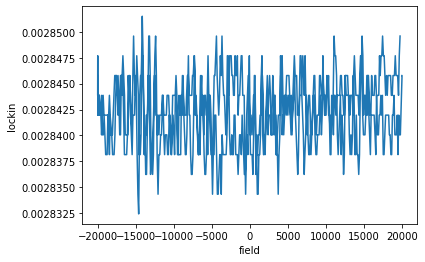

In [41]:
Power=[5]
Temp=[10]
    
for T in Temp:
    
    SetTempStable(Temp=T)
    time.sleep(10)
    A = continusfielddeolockin(fieldstart= 20000, fieldend = -20000,  signalgeneratorfre=9*1e9, power=12.5)

In [ ]:
power=5
signalgeneratorfre=9*1e9
signalgeneratorID=7


microwave = rm.open_resource('GPIB1::{}::INSTR'.format(signalgeneratorID))
microwave.write("RF0;")
microwave.write("<PL{}DB;".format(power))
microwave.write("<CW{}HZ".format(signalgeneratorfre))
microwave.write("RF1")

In [ ]:
Temp=list(np.arange(10,300,20))
print(Temp)

In [ ]:
Temp=list(np.arange(10,320,20))
for T in Temp:
    if T==2:
        time.sleep(1200)
        F=list(np.arange(2,22,2))
        print(F)
    else:
        SetTemp(Temp=T)
        time.sleep(600)
        F=list(np.arange(2,22,2))
        print(F)            
    for i in F:
        time.sleep(300)
        A = continusfielddeolockin(fieldstart=30000, fieldend = 0, signalgeneratorfre=i*1e9, power=10)
#SetTemp(Temp=300)


MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 51278)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 51278)
MultiVuServer - Client ('127.0.0.1', 51278) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 51278)
MultiVuServer - Closing connection to ('127.0.0.1', 51278)


[2, 4, 6, 8, 10, 12, 14, 16, 18, 20]


MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 50481)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 50481)


lockinmax= 0.145783
Waiting
done


MultiVuServer - Client ('127.0.0.1', 50481) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 50481)
MultiVuServer - Closing connection to ('127.0.0.1', 50481)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 53546)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 53546)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\

lockinmax= 0.0925984
Waiting
done


MultiVuServer - Client ('127.0.0.1', 53546) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 53546)
MultiVuServer - Closing connection to ('127.0.0.1', 53546)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 57074)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 57074)


lockinmax= 0.0319293
Waiting
done


MultiVuServer - Client ('127.0.0.1', 57074) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 57074)
MultiVuServer - Closing connection to ('127.0.0.1', 57074)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 64181)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 64181)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\

lockinmax= 0.0296937
Waiting


MultiVuServer - Client ('127.0.0.1', 64181) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 64181)


done


MultiVuServer - Closing connection to ('127.0.0.1', 64181)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 61317)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 61317)


lockinmax= 0.0860295
Waiting
done


MultiVuServer - Client ('127.0.0.1', 61317) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 61317)
MultiVuServer - Closing connection to ('127.0.0.1', 61317)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 51549)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 51549)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\

lockinmax= 0.0341952
Waiting


MultiVuServer - Client ('127.0.0.1', 51549) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 51549)


done


MultiVuServer - Closing connection to ('127.0.0.1', 51549)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 52811)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 52811)


lockinmax= 0.0279161
Waiting
done


MultiVuServer - Client ('127.0.0.1', 52811) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 52811)
MultiVuServer - Closing connection to ('127.0.0.1', 52811)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55704)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55704)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\

lockinmax= 0.0100785
Waiting


MultiVuServer - Client ('127.0.0.1', 55704) disconnected.


done


MultiVuClient - Closing connection to ('127.0.0.1', 55704)
MultiVuServer - Closing connection to ('127.0.0.1', 55704)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 57148)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 57148)


lockinmax= 0.0343401
Waiting
done


MultiVuServer - Client ('127.0.0.1', 57148) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 57148)
MultiVuServer - Closing connection to ('127.0.0.1', 57148)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 53989)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 53989)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\

lockinmax= 0.0331271
Waiting
done


MultiVuServer - Client ('127.0.0.1', 53989) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 53989)
MultiVuServer - Closing connection to ('127.0.0.1', 53989)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 54005)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 54005)
MultiVuServer - Client ('127.0.0.1', 54005) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 54005)
MultiVuServer - Closing connection to ('127.0.0.1', 54005)


[2, 4, 6, 8, 10, 12, 14, 16, 18, 20]


MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56776)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56776)


lockinmax= 0.147355
Waiting
done


MultiVuServer - Client ('127.0.0.1', 56776) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 56776)
MultiVuServer - Closing connection to ('127.0.0.1', 56776)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 60950)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 60950)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\

lockinmax= 0.0950704
Waiting
done


MultiVuServer - Client ('127.0.0.1', 60950) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 60950)
MultiVuServer - Closing connection to ('127.0.0.1', 60950)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 59146)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 59146)


lockinmax= 0.0325625
Waiting


MultiVuServer - Client ('127.0.0.1', 59146) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 59146)


done


MultiVuServer - Closing connection to ('127.0.0.1', 59146)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 54600)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 54600)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

lockinmax= 0.0262529
Waiting
done


MultiVuServer - Client ('127.0.0.1', 54600) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 54600)
MultiVuServer - Closing connection to ('127.0.0.1', 54600)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 51630)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 51630)


lockinmax= 0.0892034
Waiting


--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
Call stack:
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 890, in _bootstrap
    self._bootstrap_inner()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-pac

done


MultiVuServer - Client ('127.0.0.1', 51630) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 51630)
MultiVuServer - Closing connection to ('127.0.0.1', 51630)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 51991)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 51991)


lockinmax= 0.0332186
Waiting
done


MultiVuServer - Client ('127.0.0.1', 51991) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 51991)
MultiVuServer - Closing connection to ('127.0.0.1', 51991)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 52975)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 52975)


lockinmax= 0.0261079
Waiting


--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
Call stack:
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 890, in _bootstrap
    self._bootstrap_inner()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-pac

done


MultiVuServer - Closing connection to ('127.0.0.1', 52975)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 52801)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 52801)


lockinmax= 0.00999457
Waiting


MultiVuServer - Client ('127.0.0.1', 52801) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 52801)


done


MultiVuServer - Closing connection to ('127.0.0.1', 52801)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 61896)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 61896)


lockinmax= 0.0346072
Waiting


--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
Call stack:
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 890, in _bootstrap
    self._bootstrap_inner()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-pac

done


MultiVuServer - Closing connection to ('127.0.0.1', 61896)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 65211)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 65211)


lockinmax= 0.0331347
Waiting


MultiVuServer - Client ('127.0.0.1', 65211) disconnected.


done


MultiVuClient - Closing connection to ('127.0.0.1', 65211)
MultiVuServer - Closing connection to ('127.0.0.1', 65211)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 63286)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 63286)
MultiVuServer - Client ('127.0.0.1', 63286) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 63286)
MultiVuServer - Closing connection to ('127.0.0.1', 63286)


[2, 4, 6, 8, 10, 12, 14, 16, 18, 20]


MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 50256)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 50256)


lockinmax= 0.146058
Waiting


--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
Call stack:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C

done


MultiVuServer - Closing connection to ('127.0.0.1', 50256)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 54103)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 54103)


lockinmax= 0.0906758
Waiting


MultiVuServer - Client ('127.0.0.1', 54103) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 54103)


done


MultiVuServer - Closing connection to ('127.0.0.1', 54103)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 61610)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 61610)


lockinmax= 0.0305177
Waiting


--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
Call stack:
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 890, in _bootstrap
    self._bootstrap_inner()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-pac

done


MultiVuClient - Closing connection to ('127.0.0.1', 61610)
MultiVuServer - Closing connection to ('127.0.0.1', 61610)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 63402)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 63402)


lockinmax= 0.0258714
Waiting


MultiVuServer - Client ('127.0.0.1', 63402) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 63402)


done


MultiVuServer - Closing connection to ('127.0.0.1', 63402)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 57513)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 57513)


lockinmax= 0.0814824
Waiting


--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
Call stack:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C

MultiVuServer - Client ('127.0.0.1', 57513) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 57513)


done


MultiVuServer - Closing connection to ('127.0.0.1', 57513)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55372)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55372)


lockinmax= 0.0318301
Waiting
done


MultiVuServer - Client ('127.0.0.1', 55372) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 55372)
MultiVuServer - Closing connection to ('127.0.0.1', 55372)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 52381)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 52381)


lockinmax= 0.0300828
Waiting


--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
Call stack:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C

done


MultiVuServer - Closing connection to ('127.0.0.1', 52381)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 64954)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 64954)


lockinmax= 0.00664523
Waiting
done


MultiVuServer - Client ('127.0.0.1', 64954) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 64954)
MultiVuServer - Closing connection to ('127.0.0.1', 64954)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 53932)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 53932)


lockinmax= 0.0391543
Waiting


--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
Call stack:
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 890, in _bootstrap
    self._bootstrap_inner()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-pac

done


MultiVuServer - Client ('127.0.0.1', 53932) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 53932)
MultiVuServer - Closing connection to ('127.0.0.1', 53932)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55773)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55773)


lockinmax= 0.0352252
Waiting
done


MultiVuServer - Client ('127.0.0.1', 55773) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 55773)
MultiVuServer - Closing connection to ('127.0.0.1', 55773)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 63615)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 63615)
MultiVuServer - Client ('127.0.0.1', 63615) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 63615)
MultiVuServer - Closing connection to ('127.0.0.1', 63615)


[2, 4, 6, 8, 10, 12, 14, 16, 18, 20]


MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 52926)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 52926)


lockinmax= 0.141992
Waiting


--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
Call stack:
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 890, in _bootstrap
    self._bootstrap_inner()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-pac

done


MultiVuServer - Closing connection to ('127.0.0.1', 52926)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 53607)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 53607)


lockinmax= 0.0901113
Waiting


MultiVuServer - Client ('127.0.0.1', 53607) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 53607)


done


MultiVuServer - Closing connection to ('127.0.0.1', 53607)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 52165)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 52165)


lockinmax= 0.0298158
Waiting


--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
Call stack:
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 890, in _bootstrap
    self._bootstrap_inner()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-pac

done


MultiVuServer - Closing connection to ('127.0.0.1', 52165)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 61082)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 61082)


lockinmax= 0.0294648
Waiting


MultiVuServer - Client ('127.0.0.1', 61082) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 61082)


done


MultiVuServer - Closing connection to ('127.0.0.1', 61082)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 52116)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 52116)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

lockinmax= 0.0764394
Waiting


MultiVuServer - Client ('127.0.0.1', 52116) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 52116)


done


MultiVuServer - Closing connection to ('127.0.0.1', 52116)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 52382)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 52382)


lockinmax= 0.0327532
Waiting
done


MultiVuServer - Client ('127.0.0.1', 52382) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 52382)
MultiVuServer - Closing connection to ('127.0.0.1', 52382)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 60692)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 60692)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\

lockinmax= 0.0358737
Waiting


MultiVuServer - Client ('127.0.0.1', 60692) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 60692)


done


MultiVuServer - Closing connection to ('127.0.0.1', 60692)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 54121)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 54121)


lockinmax= 0.00417331
Waiting


MultiVuServer - Client ('127.0.0.1', 54121) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 54121)


done


MultiVuServer - Closing connection to ('127.0.0.1', 54121)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56029)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56029)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

lockinmax= 0.0442431
Waiting


MultiVuServer - Client ('127.0.0.1', 56029) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 56029)


done


MultiVuServer - Closing connection to ('127.0.0.1', 56029)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 50629)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 50629)


lockinmax= 0.0387042
Waiting


MultiVuServer - Client ('127.0.0.1', 50629) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 50629)


done


MultiVuServer - Closing connection to ('127.0.0.1', 50629)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 50129)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 50129)
MultiVuServer - Client ('127.0.0.1', 50129) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 50129)
MultiVuServer - Closing connection to ('127.0.0.1', 50129)


[2, 4, 6, 8, 10, 12, 14, 16, 18, 20]


MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55929)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55929)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
Call stack:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", 

lockinmax= 0.145761
Waiting


MultiVuServer - Client ('127.0.0.1', 55929) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 55929)


done


MultiVuServer - Closing connection to ('127.0.0.1', 55929)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 62610)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 62610)


lockinmax= 0.0916829
Waiting
done


MultiVuServer - Client ('127.0.0.1', 62610) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 62610)
MultiVuServer - Closing connection to ('127.0.0.1', 62610)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 64405)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 64405)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\

--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
Call stack:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C

lockinmax= 0.0314715
Waiting
done


MultiVuServer - Client ('127.0.0.1', 64405) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 64405)
MultiVuServer - Closing connection to ('127.0.0.1', 64405)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 61238)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 61238)


lockinmax= 0.0339587
Waiting


--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
Call stack:
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 890, in _bootstrap
    self._bootstrap_inner()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-pac

done


MultiVuServer - Client ('127.0.0.1', 61238) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 61238)
MultiVuServer - Closing connection to ('127.0.0.1', 61238)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 60109)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 60109)


lockinmax= 0.0723119
Waiting
done


MultiVuServer - Client ('127.0.0.1', 60109) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 60109)
MultiVuServer - Closing connection to ('127.0.0.1', 60109)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 58688)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 58688)
MultiVuClient - 
MultiVuClient - Caught keyboard interrupt, exiting
MultiVuClient - Closing connection to ('127.0.0.1', 58688)
MultiVuServer - Closing connection to ('127.0.0.1', 58688)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 60854)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 60854)


lockinmax= 0.0054169
Waiting


--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
Call stack:
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 890, in _bootstrap
    self._bootstrap_inner()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-pac

done


MultiVuServer - Closing connection to ('127.0.0.1', 60854)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 57316)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 57316)


lockinmax= 0.0011139
Waiting


MultiVuClient - 
MultiVuClient - Caught keyboard interrupt, exiting
MultiVuClient - Closing connection to ('127.0.0.1', 57316)
MultiVuServer - Closing connection to ('127.0.0.1', 57316)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 64586)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 64586)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\

In [ ]:
L=list(np.arange(freq_min,freq_max+1,freq_step))
print(L)
for i in L:
    print(i, '\n')

In [ ]:
file_name = "Tao/" + sample_id + "_" + str(T) + "K_" + str(freq) + 'GHz_' + str(power) + 'dBm'+ str(fileID) + ".csv"
            with open(file_name, 'a') as f:
                    f.write("{},{},{},{}, {}\n".format('freq', 'field', 'Rxy1_X', 'Rxy1_Y', 'Temp'))

In [ ]:
 print(powerarr, '\n')

In [ ]:
freq_min, freq_max = 10, 14 # GHz
freq_step = -1 # GHz
field_read_min, field_read_max = 200, 15000 # Oe
Sens=[0.005, 0.010, 0.020, 0.020]
powerarr=list(np.arange(-5,15,5))
field_sat = 20000.0
sample_id = 'CGT'
T = 4.3
fileID = 7
microwave.write(":POW:STAT ON;")

L=list(np.arange(freq_max,freq_min,freq_step))
for power in {-5,0}:
    index = powerarr.index(power)
    print(index)
    lock2.change_harmonic(sens=Sens[index])
    time.sleep(10)
    for freq in L:
        microwave.write(":FREQ:CW {} Hz;:FREQ:MODE FIX;".format(freq*1e9))
        microwave.write(":POW:MODE FIX;LEV {};".format(power))
        time.sleep(10)
        B=lock2.lock_in_measure(count=1, time_step=0.1, wait_before_measure=0.1)
        print(B)
                
microwave.write(":POW:STAT OFF;")

In [ ]:
powerarr=list(np.arange(-5,15,5))
for power in {-5,0}:
    index = powerarr.index(power)
    print(index)

In [ ]:
B=lock2.lock_in_measure(count=1, time_step=0.1, wait_before_measure=0.1)

In [ ]:
print(B)